# Import các thứ viện cần thiết

In [2]:
import pandas as pd
import numpy as np
import torch
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import random

In [6]:
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 1e-5
MAX_LENGTH = 384
STRIDE = 128
MODEL_NAME = "deepset/roberta-base-squad2"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {DEVICE}")

Sử dụng thiết bị: cpu


In [31]:
# tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")
# model = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")

model_path = "badminton_qa_model"  

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForQuestionAnswering.from_pretrained(model_path)

In [100]:
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

question = "Are there any courts near Old Quarter?"
context = "You can find the location of the course in the 'Course Details'"

result = qa_pipeline(question=question, context=context)

print("Answer:", result["answer"])

Device set to use mps:0


Answer: Details'


In [55]:
df = pd.read_csv('data/Question.csv')

In [56]:
df.head(5)

,Question,Answer
0,How do I book a badminton court?,"You can book a court by logging in, choosing a..."
1,Can I cancel my court reservation?,"Yes, you can cancel your reservation from your..."
2,Where can I see all available badminton courts?,You can view all available courts on the 'Book...
3,What if I forget my login password?,Click 'Forgot Password' on the login page and ...
4,Is there a fee for canceling a booking?,"No, cancellation is free if done at least 1 ho..."


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  300 non-null    object
 1   Answer    300 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


In [58]:
def convert_to_squad_format(df):
    squad_data = {
        "data": []
    }
    
    # Tạo một context chung từ tất cả các câu hỏi và câu trả lời
    complete_context = ""
    qa_pairs = []
    
    for index, row in df.iterrows():
        question = row['Question']
        answer = row['Answer']
        
        # Thêm câu hỏi và câu trả lời vào context
        current_qa = f"Question: {question}\nAnswer: {answer}\n\n"
        start_idx = len(complete_context)
        complete_context += current_qa
        
        # Lưu lại vị trí bắt đầu của câu trả lời trong context
        answer_start = start_idx + len(f"Question: {question}\nAnswer: ")
        
        qa_pairs.append({
            "question": question,
            "answer": {
                "text": answer,
                "answer_start": answer_start
            }
        })
    
    # Tạo một entry duy nhất trong dữ liệu SQuAD với context chung
    squad_entry = {
        "title": "Badminton Court Management FAQ",
        "paragraphs": [{
            "context": complete_context,
            "qas": []
        }]
    }
    
    # Thêm các cặp question-answer vào entry
    for i, qa in enumerate(qa_pairs):
        squad_entry["paragraphs"][0]["qas"].append({
            "id": f"id-{i}",
            "question": qa["question"],
            "answers": [{
                "text": qa["answer"]["text"],
                "answer_start": qa["answer"]["answer_start"]
            }]
        })
    
    squad_data["data"].append(squad_entry)
    return squad_data

In [59]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Tập huấn luyện: {len(train_df)} mẫu, Tập kiểm thử: {len(test_df)} mẫu")

Tập huấn luyện: 240 mẫu, Tập kiểm thử: 60 mẫu


In [60]:
# Cell 6: Tạo Dataset và DataLoader
class QADataset(Dataset):
    def __init__(self, squad_data, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.stride = stride
        self.examples = []
        self.features = []
        
        # Chuyển đổi dữ liệu SQuAD thành features
        for article in squad_data["data"]:
            for paragraph in article["paragraphs"]:
                context = paragraph["context"]
                
                for qa in paragraph["qas"]:
                    question = qa["question"]
                    answer = qa["answers"][0]
                    
                    # Tokenize question và context
                    inputs = tokenizer(
                        question,
                        context,
                        max_length=max_length,
                        stride=stride,
                        truncation="only_second",
                        return_overflowing_tokens=True,
                        return_offsets_mapping=True,
                        padding="max_length"
                    )
                    
                    offset_mapping = inputs.pop("offset_mapping")
                    
                    for i, offset in enumerate(offset_mapping):
                        input_ids = inputs["input_ids"][i]
                        attention_mask = inputs["attention_mask"][i]
                        
                        # Tìm vị trí start và end cho câu trả lời
                        start_position = 0
                        end_position = 0
                        
                        # Vị trí bắt đầu và kết thúc của câu trả lời trong context
                        answer_start = answer["answer_start"]
                        answer_end = answer_start + len(answer["text"])
                        
                        # Tìm các tokens tương ứng với vị trí bắt đầu và kết thúc
                        for idx, (token_start, token_end) in enumerate(offset):
                            if token_start <= answer_start and token_end > answer_start:
                                start_position = idx
                            if token_start < answer_end and token_end >= answer_end:
                                end_position = idx
                        
                        self.features.append({
                            "input_ids": input_ids,
                            "attention_mask": attention_mask,
                            "start_positions": start_position,
                            "end_positions": end_position
                        })
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        return {
            "input_ids": torch.tensor(feature["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(feature["attention_mask"], dtype=torch.long),
            "start_positions": torch.tensor(feature["start_positions"], dtype=torch.long),
            "end_positions": torch.tensor(feature["end_positions"], dtype=torch.long)
        }

In [61]:
train_squad = convert_to_squad_format(train_df)
test_squad = convert_to_squad_format(test_df)

# Tạo dataset và dataloader
train_dataset = QADataset(train_squad, tokenizer, MAX_LENGTH, STRIDE)
test_dataset = QADataset(test_squad, tokenizer, MAX_LENGTH, STRIDE)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Số lượng features trong tập huấn luyện: {len(train_dataset)}")
print(f"Số lượng features trong tập kiểm thử: {len(test_dataset)}")

Số lượng features trong tập huấn luyện: 6859
Số lượng features trong tập kiểm thử: 420


In [62]:
def train_model(model, dataloader, optimizer, device, num_epochs):
    model.to(device)
    model.train()
    
    losses = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        epoch_loss = 0
        
        progress_bar = tqdm(dataloader, desc=f"Training Epoch {epoch+1}")
        
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                start_positions=start_positions,
                end_positions=end_positions
            )
            
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        avg_epoch_loss = epoch_loss / len(dataloader)
        losses.append(avg_epoch_loss)
        print(f"Epoch {epoch+1} - Mất mát trung bình: {avg_epoch_loss:.4f}")
    
    return losses

In [63]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

print("Bắt đầu huấn luyện mô hình với tập huấn luyện...")
losses = train_model(model, train_dataloader, optimizer, DEVICE, EPOCHS)

Bắt đầu huấn luyện mô hình với tập huấn luyện...
Epoch 1/15


Training Epoch 1: 100%|██████████| 858/858 [1:20:56<00:00,  5.66s/it, loss=0.0047]


Epoch 1 - Mất mát trung bình: 0.0400
Epoch 2/15


Training Epoch 2: 100%|██████████| 858/858 [1:08:09<00:00,  4.77s/it, loss=0.0023]


Epoch 2 - Mất mát trung bình: 0.0290
Epoch 3/15


Training Epoch 3: 100%|██████████| 858/858 [1:08:34<00:00,  4.80s/it, loss=0.0005]


Epoch 3 - Mất mát trung bình: 0.0203
Epoch 4/15


Training Epoch 4: 100%|██████████| 858/858 [1:07:52<00:00,  4.75s/it, loss=0.0000]


Epoch 4 - Mất mát trung bình: 0.0123
Epoch 5/15


Training Epoch 5: 100%|██████████| 858/858 [1:08:20<00:00,  4.78s/it, loss=0.0005]


Epoch 5 - Mất mát trung bình: 0.0175
Epoch 6/15


Training Epoch 6: 100%|██████████| 858/858 [1:09:08<00:00,  4.84s/it, loss=0.0002]


Epoch 6 - Mất mát trung bình: 0.0119
Epoch 7/15


Training Epoch 7: 100%|██████████| 858/858 [1:26:09<00:00,  6.02s/it, loss=0.0003]  


Epoch 7 - Mất mát trung bình: 0.0112
Epoch 8/15


Training Epoch 8: 100%|██████████| 858/858 [1:27:32<00:00,  6.12s/it, loss=0.0005] 


Epoch 8 - Mất mát trung bình: 0.0093
Epoch 9/15


Training Epoch 9: 100%|██████████| 858/858 [1:19:24<00:00,  5.55s/it, loss=0.1423]


Epoch 9 - Mất mát trung bình: 0.0090
Epoch 10/15


Training Epoch 10: 100%|██████████| 858/858 [1:05:29<00:00,  4.58s/it, loss=0.0000]


Epoch 10 - Mất mát trung bình: 0.0103
Epoch 11/15


Training Epoch 11: 100%|██████████| 858/858 [1:23:41<00:00,  5.85s/it, loss=0.0000]   


Epoch 11 - Mất mát trung bình: 0.0066
Epoch 12/15


Training Epoch 12: 100%|██████████| 858/858 [1:29:19<00:00,  6.25s/it, loss=0.0120]


Epoch 12 - Mất mát trung bình: 0.0071
Epoch 13/15


Training Epoch 13: 100%|██████████| 858/858 [2:53:18<00:00, 12.12s/it, loss=0.0000]    


Epoch 13 - Mất mát trung bình: 0.0100
Epoch 14/15


Training Epoch 14: 100%|██████████| 858/858 [1:10:56<00:00,  4.96s/it, loss=0.0003]


Epoch 14 - Mất mát trung bình: 0.0083
Epoch 15/15


Training Epoch 15: 100%|██████████| 858/858 [1:09:55<00:00,  4.89s/it, loss=0.0000]

Epoch 15 - Mất mát trung bình: 0.0053


In [64]:
def evaluate_model(model, dataloader, tokenizer, device):
    model.to(device)
    model.eval()
    
    exact_match = 0
    f1_score = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Đánh giá"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits
            
            for i in range(len(input_ids)):
                # Lấy vị trí có điểm cao nhất
                start_pred = torch.argmax(start_logits[i]).item()
                end_pred = torch.argmax(end_logits[i]).item()
                
                # Vị trí thực tế
                start_true = start_positions[i].item()
                end_true = end_positions[i].item()
                
                # Tính toán exact match
                if start_pred == start_true and end_pred == end_true:
                    exact_match += 1
                
                # Tính toán F1 score
                pred_tokens = set(range(start_pred, end_pred + 1))
                true_tokens = set(range(start_true, end_true + 1))
                
                common_tokens = len(pred_tokens.intersection(true_tokens))
                
                if len(pred_tokens) == 0 or len(true_tokens) == 0:
                    f1 = 0
                else:
                    precision = common_tokens / len(pred_tokens)
                    recall = common_tokens / len(true_tokens)
                    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                
                f1_score += f1
                total += 1
    
    exact_match_score = exact_match / total if total > 0 else 0
    f1_score = f1_score / total if total > 0 else 0
    
    return {
        "exact_match": exact_match_score,
        "f1_score": f1_score
    }

In [67]:
results = evaluate_model(model, test_dataloader, tokenizer, "cpu")

print("📊 Exact Match:", results["exact_match"])
print("📈 F1 Score:", results["f1_score"])

Đánh giá: 100%|██████████| 53/53 [01:00<00:00,  1.13s/it]

📊 Exact Match: 0.9928571428571429
📈 F1 Score: 0.9889466089466088


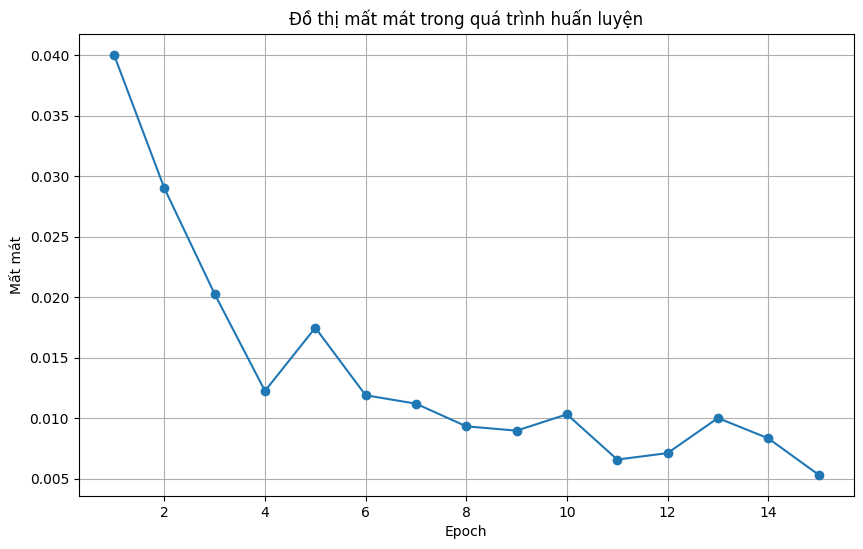

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.title('Đồ thị mất mát trong quá trình huấn luyện')
plt.xlabel('Epoch')
plt.ylabel('Mất mát')
plt.grid(True)
plt.show()

In [69]:
def predict_answer(question, context, model, tokenizer, device='cpu'):
    model.to(device)
    model.eval()
    
    # Tokenize câu hỏi và context
    inputs = tokenizer(
        question,
        context,
        max_length=384,
        truncation="only_second",
        return_tensors="pt"
    )
    
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
    
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits
    
    start_idx = torch.argmax(start_logits).item()
    end_idx = torch.argmax(end_logits).item()
    
    # Đảm bảo end_idx >= start_idx
    if end_idx < start_idx:
        end_idx = start_idx
    
    # Chuyển đổi token index thành text
    answer_tokens = input_ids[0][start_idx:end_idx+1]
    answer = tokenizer.decode(answer_tokens)
    
    return answer

Test xem model có hiểu context không 

In [70]:
test_questions = [
    "Can I login by facebook account?",
    "Can I create two accounts with the same email?",
    "Do you offer both indoor and outdoor courts?",
    "How do I find out where the court is?",
]

In [71]:
model_path = "badminton_qa_model"  

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForQuestionAnswering.from_pretrained(model_path)

def test_model_with_single_context(question, model, tokenizer, df):
    # Tìm câu trả lời thực tế
    actual_answer = df[df['Question'] == question]['Answer'].values[0]
    
    context = f"Question: {question}\nAnswer: {actual_answer}"
    
    # Sử dụng pipeline
    nlp = pipeline("question-answering", model=model, tokenizer=tokenizer)
    result = nlp(question=question, context=context)
    
    print(f"Câu hỏi: {question}")
    print(f"Câu trả lời dự đoán: {result['answer']}")
    print(f"Câu trả lời thực tế: {actual_answer}")
    print(f"Độ tin cậy: {result['score']:.4f}")
    print("-----")
    
    return result

# Kiểm tra
for question in test_questions:
    test_model_with_single_context(question, model, tokenizer, df)

Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0


Câu hỏi: Can I login by facebook account?
Câu trả lời dự đoán: Yes, you can login by facebook account.
Câu trả lời thực tế: Yes, you can login by facebook account.
Độ tin cậy: 0.9948
-----
Câu hỏi: Can I create two accounts with the same email?
Câu trả lời dự đoán: We currently only allow one account per email address.
Câu trả lời thực tế: We currently only allow one account per email address.
Độ tin cậy: 0.9974
-----
Câu hỏi: Do you offer both indoor and outdoor courts?
Câu trả lời dự đoán: We only have indoor badminton courts.
Câu trả lời thực tế: We only have indoor badminton courts.
Độ tin cậy: 0.9898
-----
Câu hỏi: How do I find out where the court is?
Câu trả lời dự đoán: You can find the court location in the Court Details.
Câu trả lời thực tế: You can find the court location in the Court Details.
Độ tin cậy: 0.9980
-----


In [33]:
# import asyncio
# from googletrans import Translator

# translator = Translator()

# async def translate_text():
#     translated_question = await translator.translate("Làm sao để đặt sân cầu lông?", src='vi', dest='en')
#     translated_answer = await translator.translate("How do I book a court?", src='en', dest='vi')
#     print("Tiếng Anh:", translated_question.text)
#     print("Tiếng Việt:", translated_answer.text)

# await translate_text()

Tiếng Anh: How to place badminton yard?
Tiếng Việt: Làm cách nào để đặt một tòa án?


In [72]:
# # Tạo thư mục để lưu mô hình
output_dir = "badminton_qa_model"
os.makedirs(output_dir, exist_ok=True)

# Lưu mô hình
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Đã lưu mô hình và tokenizer vào thư mục '{output_dir}'")

Đã lưu mô hình và tokenizer vào thư mục 'badminton_qa_model'


In [73]:
# Tạo từ điển chủ đề
topic_dict = {
    "booking": ["book", "reservation", "schedule", "available", "court", "time", "slot", "booking", "reschedule", "tournament", "organize", "session", "reserve", "advance", "statistics", "history", "past"],
    "account": ["personal", "information", "login", "password", "register", "account", "profile", "signin", "signup", "forgot", "email", "facebook", "instagram", "twitter", "tiktok", "zalo", "microsoft", "phone", "reset", "create", "sign up", "format"],
    "equipment": ["racket", "rent", "shuttlecock", "equipment", "purchase", "buy", "drinks", "water"],
    "facilities": ["changing room", "locker", "parking", "facility", "toilet", "shower", "indoor", "outdoor", "location", "address"],
    "payment": ["pay", "payment", "fee", "cost", "price", "refund", "cancel", "money","charged", "free", "rate", "hourly", "vnd"],
    "contact": ["contact", "staff", "help", "support", "question", "assistance", "email", "call", "hotline", "phone", "message", "reply", "respond", "inquiry", "email", "hotline"],
    "website": ["news", "updates", "promotions", "discounts", "services", "policy", "terms", "guidelines", "introduction", "homepage", "section", "button"],
    "misc": []  # Mặc định cho câu hỏi không thuộc chủ đề nào
}

# Xác định chủ đề cho câu hỏi
def identify_topic(question):
    question = question.lower()
    
    # Kiểm tra từng chủ đề
    for topic, keywords in topic_dict.items():
        for keyword in keywords:
            if keyword in question:
                return topic
    
    return "misc"  # Chủ đề mặc định

# Tạo context theo chủ đề
def create_topic_contexts(df):
    topic_contexts = {}
    
    # Khởi tạo context cho mỗi chủ đề
    for topic in topic_dict.keys():
        topic_contexts[topic] = ""
    
    # Phân loại câu hỏi vào các chủ đề
    for _, row in df.iterrows():
        question = row['Question']
        answer = row['Answer']
        
        # Xác định chủ đề
        topic = identify_topic(question)
        
        # Thêm vào context của chủ đề tương ứng
        topic_contexts[topic] += f"Question: {question}\nAnswer: {answer}\n\n"
    
    return topic_contexts

In [75]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Tải mô hình embedding
embedding_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

# Tạo embeddings cho tất cả câu hỏi
def create_question_embeddings(df):
    questions = df['Question'].tolist()
    embeddings = embedding_model.encode(questions)
    return embeddings

# Tìm câu hỏi tương tự nhất
def find_similar_questions(question, df, embeddings, top_k=3):
    # Tạo embedding cho câu hỏi
    question_embedding = embedding_model.encode([question])[0]
    
    # Tính độ tương đồng
    similarities = cosine_similarity([question_embedding], embeddings)[0]
    
    # Lấy top_k câu hỏi có độ tương đồng cao nhất
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    # Tạo context từ top_k câu hỏi
    context = ""
    for idx in top_indices:
        q = df.iloc[idx]['Question']
        a = df.iloc[idx]['Answer']
        context += f"Question: {q}\nAnswer: {a}\n\n"
    
    return context, similarities[top_indices[0]]

In [76]:
# Khởi tạo
topic_contexts = create_topic_contexts(df)
embeddings = create_question_embeddings(df)

# Sử dụng
def smart_qa_system(question, df, model, tokenizer):
    # Xác định chủ đề
    topic = identify_topic(question)

    if topic == "misc":
        default_responses = [
            "I don't understand your question.", 
            "Please ask again."
        ]
        random_response = random.choice(default_responses)
        return random_response, 1.0, "default_response"

    similar_questions_df = df[df['Question'].apply(lambda q: identify_topic(q) == topic)]
    if len(similar_questions_df) > 0:
        similar_embeddings = create_question_embeddings(similar_questions_df)
        context, similarity = find_similar_questions(question, similar_questions_df, similar_embeddings)
        
        # Nếu độ tương đồng cao, trả về câu trả lời trực tiếp
        if similarity > 0.85:
            for idx in np.argsort(cosine_similarity([embedding_model.encode([question])[0]], similar_embeddings)[0])[-1:]:
                return similar_questions_df.iloc[idx]['Answer'], similarity, "direct_match"
            
    context = topic_contexts[topic]
    
    # Sử dụng pipeline question-answering
    nlp = pipeline("question-answering", model=model, tokenizer=tokenizer)
    result = nlp(question=question, context=context)
    
    return result['answer'], result['score'], "model_answer"

In [77]:

custom_questions = [
    # # Gốc
    # "Can I move my booking to a different time?",
    # "Can I sign in with TikTok?",
    # "What’s the process for changing my account details?",
    # "How do I get my refund after canceling a booking?",
    # "Can I login by facebook account?", 

    # Biến thể
    "Hi there, may I ask you some question?",
    "Where can I get a bottle of water?",
    "How can I update my account information?",
    "What should I do to receive a refund after I cancel a booking?",
    "What if I don't remember my login password?"
    # các câu hỏi này là dạng biến tấu(thay đổi các hỏi nhưng vẫn cùng 1 mục đích. Ví dụ: tối nay em ăn gì = hôm nay em ăn món gì vậy) của các câu hỏi trên
    # chúng ta sẽ kiếm tra xem model có thực sự học được khi đổi data ko, nếu nó trả lời sai => overfit(overfit là model có khả năng trả lời rát tốt theo tập dữ liệu train với khi có dữ liệu lạ thì nó lại SAI)
    # Am I able to log in using my TikTok account? ko hề có trong DATA => model đã học được và ko overfit
]

for question in custom_questions:
    predicted_answer, score_or_sim, method = smart_qa_system(question, df, model, tokenizer)
    
    print(f"\n🔹 Câu hỏi (biến tấu): {question}")
    print(f"🤖 Trả lời AI: {predicted_answer}")
    print(f"📌 Phương pháp: {method}")
    print(f"📈 Score/Similarity: {score_or_sim:.2f}")


🔹 Câu hỏi (biến tấu): Hi there, may I ask you some question?
🤖 Trả lời AI: Sure, I'm here to help! What would you like to know?
📌 Phương pháp: direct_match
📈 Score/Similarity: 0.96

🔹 Câu hỏi (biến tấu): Where can I get a bottle of water?
🤖 Trả lời AI: Yes, you can buy drinks at the front desk.
📌 Phương pháp: direct_match
📈 Score/Similarity: 1.00

🔹 Câu hỏi (biến tấu): How can I update my account information?
🤖 Trả lời AI: Go to your account settings to update your details.
📌 Phương pháp: direct_match
📈 Score/Similarity: 0.98

🔹 Câu hỏi (biến tấu): What should I do to receive a refund after I cancel a booking?
🤖 Trả lời AI: Refunds are issued if you cancel in time.
📌 Phương pháp: direct_match
📈 Score/Similarity: 0.98

🔹 Câu hỏi (biến tấu): What if I don't remember my login password?
🤖 Trả lời AI: Click 'Forgot Password' on the login page and follow the instructions to reset it.
📌 Phương pháp: direct_match
📈 Score/Similarity: 0.94
